In [4]:
library('BoolNet')
library('dplyr')
library('alluvial')
library("stringr")
library('pheatmap')
library('data.table')
for (f in list.files("BNP")) { source( paste('BNP/', f, sep='') ) }

# Load data
net <- loadNetwork(file = "CSV/MP_reduced_network_1.2.csv")


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last



## Full Regulatory Network

![title](MODEL/full_network.png)

## Reduced Regulatory Network

![title](MODEL/reduced_network_2.png)

In [42]:
file.attr <- "CSV/MP_reduced_attractors_2.csv"
if (! file.exists(file.attr)) {
      simplifyLabel <- function(old, sep='/', mark='*', replace=NULL) { 
        new <- str_split(old,sep)
        new <- sort(unique(new[[1]]))
        new <- paste(new, collapse=sep)
        if (! is.null(replace)) {
          for (key in names(replace)) {
            new <- str_replace( new, pattern=key, replace[[key]] )
          }
        }
        if (! is.null(mark)) { 
          if (new!=old) {
            new <- paste(c(new,mark), collapse='')
          }
        }
        new
      }
      lab <- read.csv("CSV/MP_label_rules_2.csv")
      labels <- labelAttractors(attr, lab, net$genes)
      replace <- list('bM1M2'='M1M2', 'il6/M0/M1/M2b'='M1M2', 'il6/M0/M2/M2b'='M2b', 'il6/M0/M2/M2c'='M2c', 'il6/M0/M1/M2'='M1M2', 
                      'M1M2/M2/M2d'='M1M2', 'il6/M1/M2b'='M1M2', 'il6/M0/M1'='M1', 'il6/M0/M2'='M2', 'M0/M1/M2b'='M1M2', 'M0/M2/M2b'='M2b', 
                      'M0/M2/M2c'='M2c', 'M1/M2/M2b'='M1M2', 'M1/M2/M2c'='M1M2', 'M0/M1/M2'='M1M2', 'il6/M2b'='M2b', 'M1M2/M2'='M1M2', 
                      'il6/M0'='il6', 'il6/M1'='M1', 'il6/M1'='M1', 'M1/M2b'='M1M2', 'M2/M2d'='M2d', 'M0/M1'='M1', 'M0/M2'='M2', 'M1/M2'='M1M2')
      
      clean.labels <- list()
      for (i in 1:length(labels)) {
        clean.labels[i] <- simplifyLabel(labels[[i]], replace=replace)
      }
      # Getting df of attractors
      clean.labels <- unlist(clean.labels)
      attr.table <- attractorToDataframe(attr, Boolean = T)
      cell.type <- c()
      n <- 1
      for (i in 1:nrow(attr.table)) {
        if (!(i == nrow(attr.table)))
          if (attr.table$state[i + 1] > attr.table$state[i]) next
        cell.type <- c(cell.type, rep(clean.labels[n], attr.table$state[i]))
        n <- n + 1
      }
      rm(clean.labels, labels)
      attr.table <- cbind(attr.table, cell.type = cell.type)
      # Sorting attractor table by estimulus
      est.ind <- (which(str_detect(colnames(attr.table), "_e") == T))
      attr.table <- attr.table[,c(1,2,est.ind ,(3:ncol(attr.table))[-(est.ind-2)])]
      attr.table <- attr.table[order(attr.table$cell.type),]
      write.csv(attr.table,file = file.attr)
} else {
      attr.table <- read.csv(file = file.attr)
}

In [43]:
# Finding the index of the end of each state
attr.table <- subset(attr.table, select = c("cell.type", "state","STAT1", "STAT5", "NFKB", "STAT6",
                                            "STAT3_IL10", "STAT3_IL6", "IL12_out", "IL10_out", "IL6_out", "VEGF_out") )
colnames(attr.table)[1] <- "attractor"
cycle.index <- data.frame()

for (i in 1:(nrow(attr.table)-1)) {
      if(attr.table$state[i] >= attr.table$state[i + 1]){
            cycle.index <- rbind(cycle.index,
                                 cbind(cycle.n = attr.table$state[i],
                                               index = i))
      }  
}
# cycle.index contains the indices of the last attractor of all states
cycle.index <- rbind(cycle.index, cbind(cycle.n = attr.table$state[i + 1],
                                        index = i + 1))
# Finding the unique cyclic states
cycle.sizes <- sort(unique(cycle.index$cycle.n))
attr.cycles.list <- list()
for (size in cycle.sizes) {
      size.indexes <- which(cycle.index$cycle.n == size)
      size.indexes <- cycle.index$index[size.indexes]
      if(size > 1){
            table.unique <- attr.table[size.indexes - (size-1),]
            for (i in (size-2):0) table.unique <- cbind(table.unique, attr.table[size.indexes - i,])
            table.unique <- unique(table.unique)
            col.factor <- (ncol(table.unique)/size)
            table <- table.unique[,1:col.factor]
            for (i in seq(col.factor + 1,ncol(table.unique),ncol(table.unique) / size)) {
                  table <- rbind(table,
                                 table.unique[,i:(i+(col.factor-1))])
            }
            indexing.ord <- c()
            for (i in 1:(nrow(table)/size)) indexing.ord <- c(indexing.ord, seq(i, nrow(table), nrow(table)/size))
            table <- table[indexing.ord,]
      } else { table <- unique(attr.table[size.indexes,])}
      attr.cycles.list[[size]] <- table
}

rm(size.indexes, size, cycle.index, i, table.unique, indexing.ord, table)

[1] 1
[1] 2


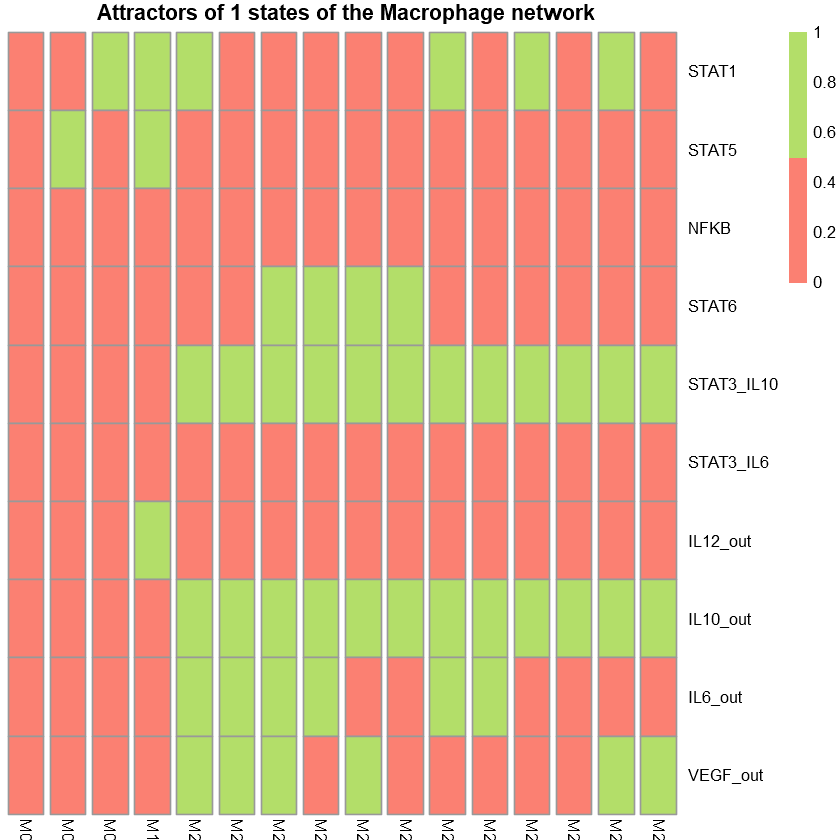

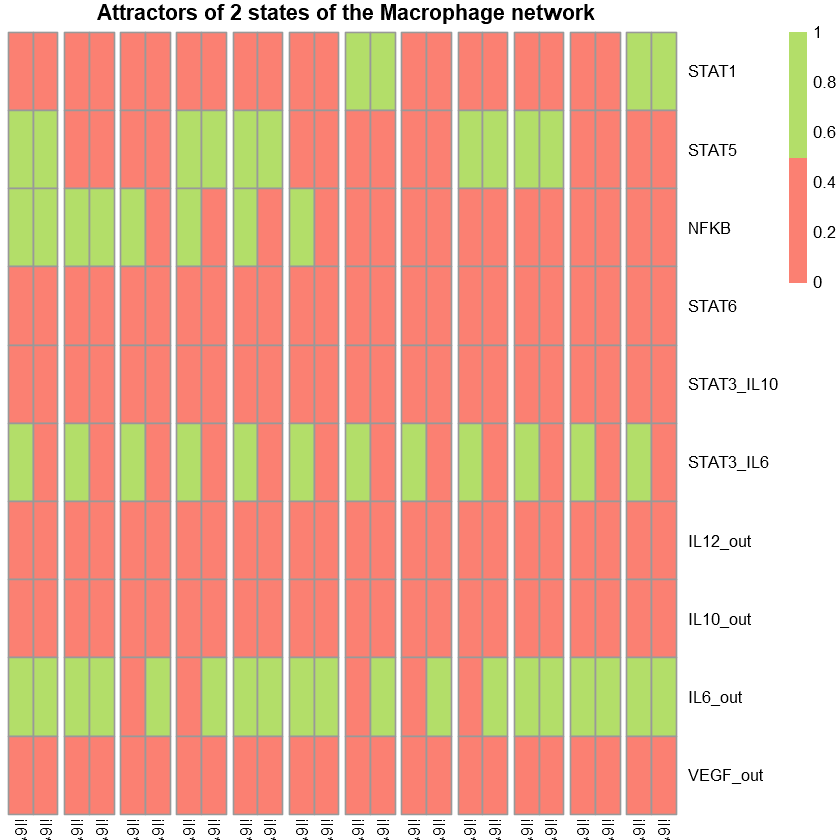

[1] 3


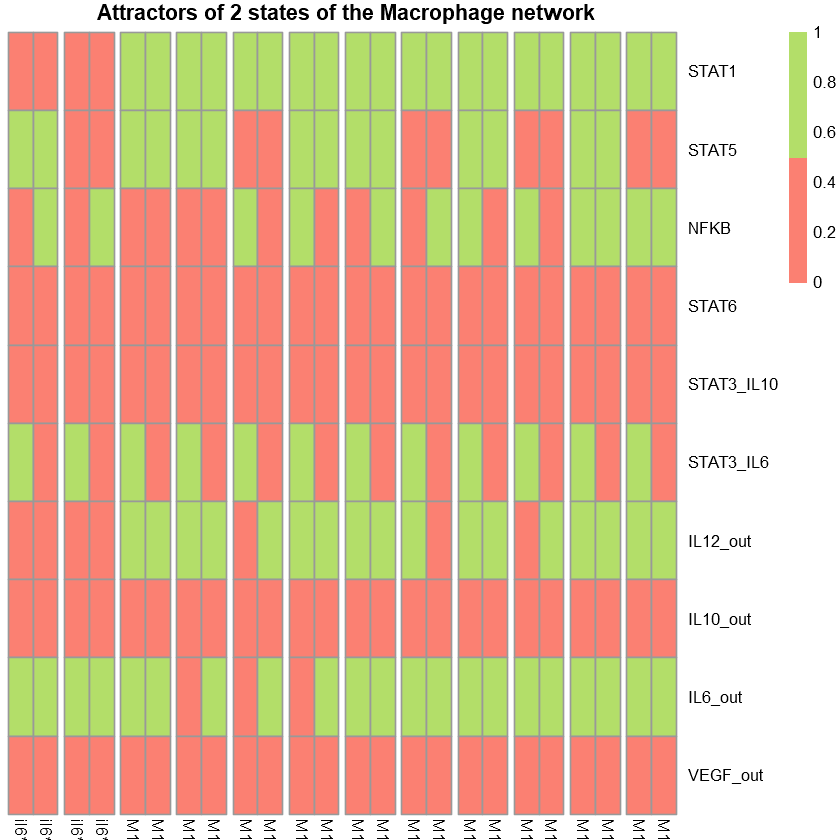

[1] 6


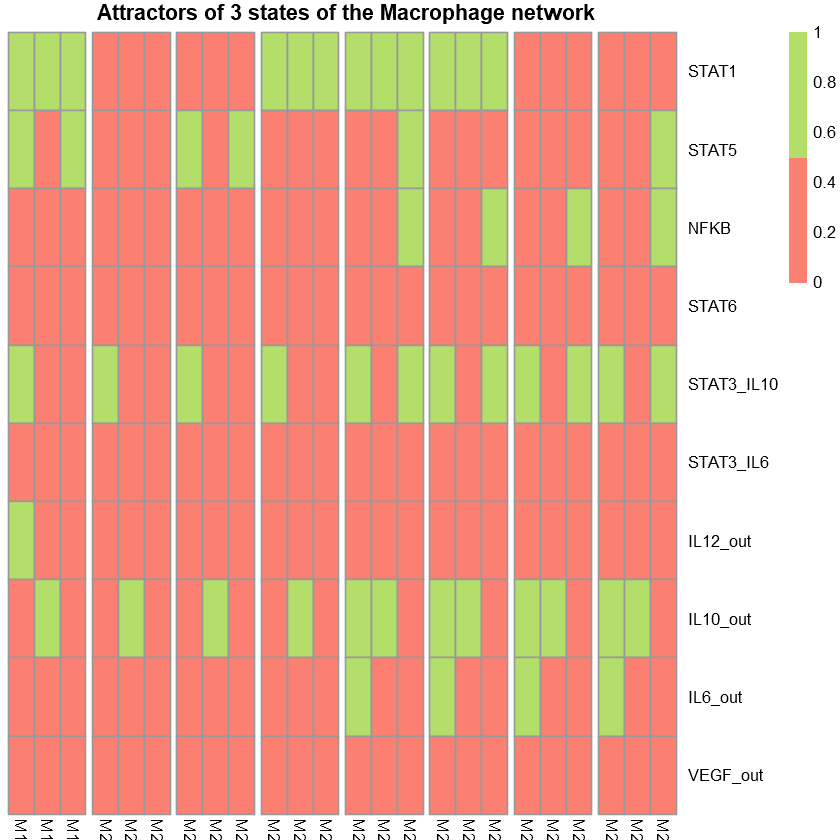

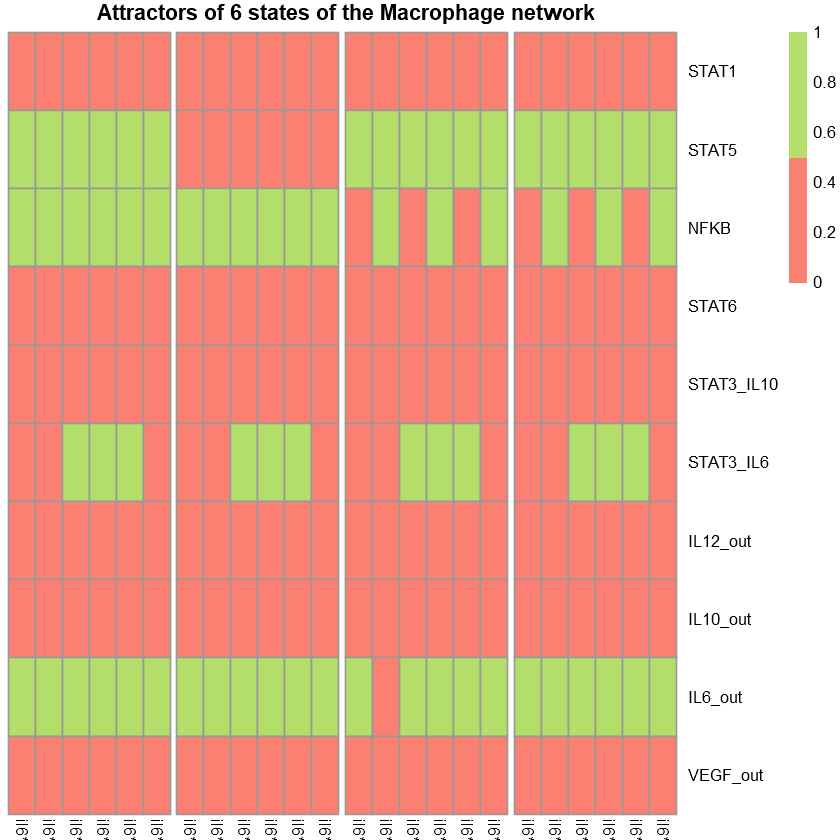

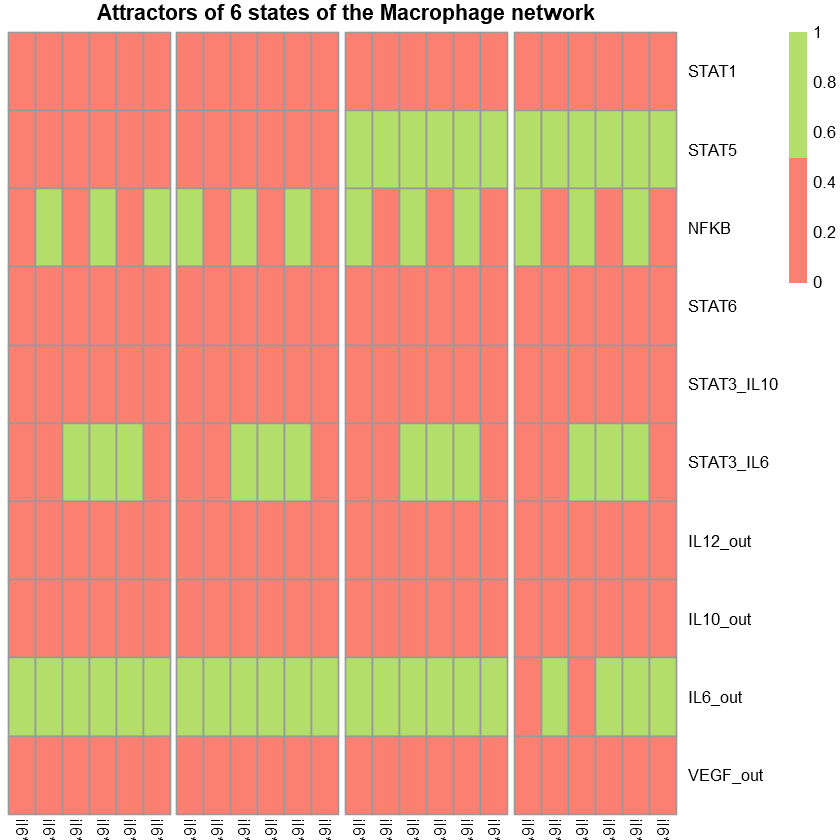

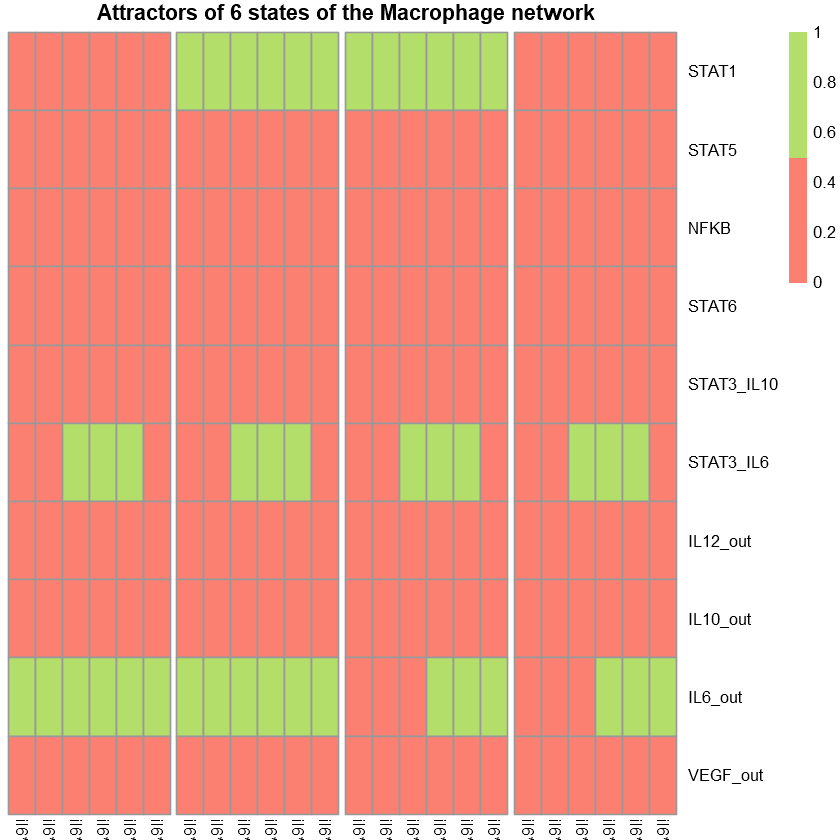

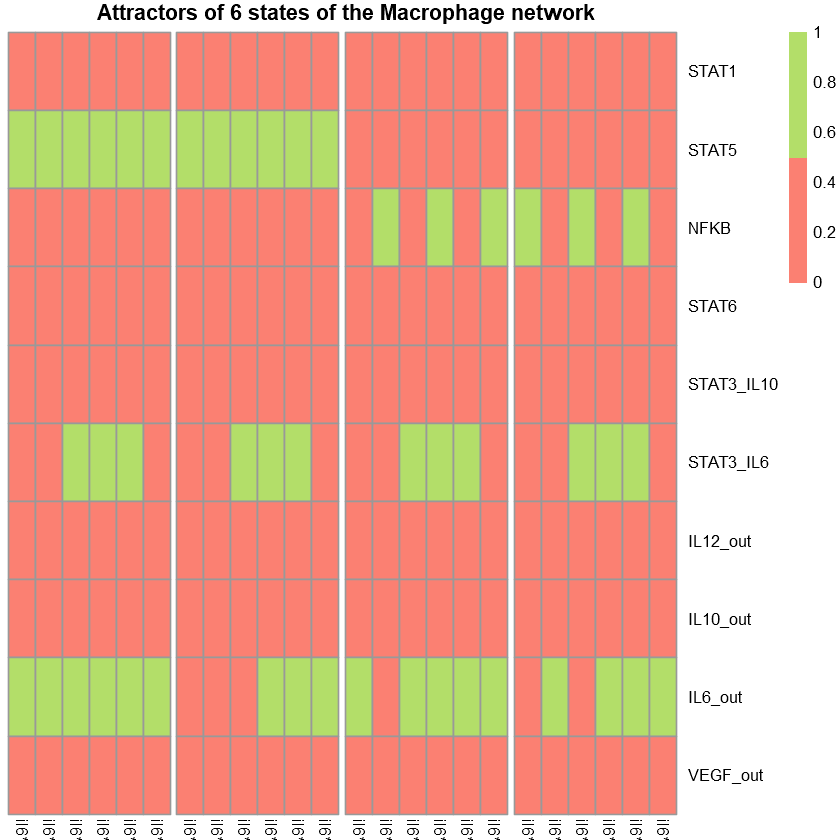

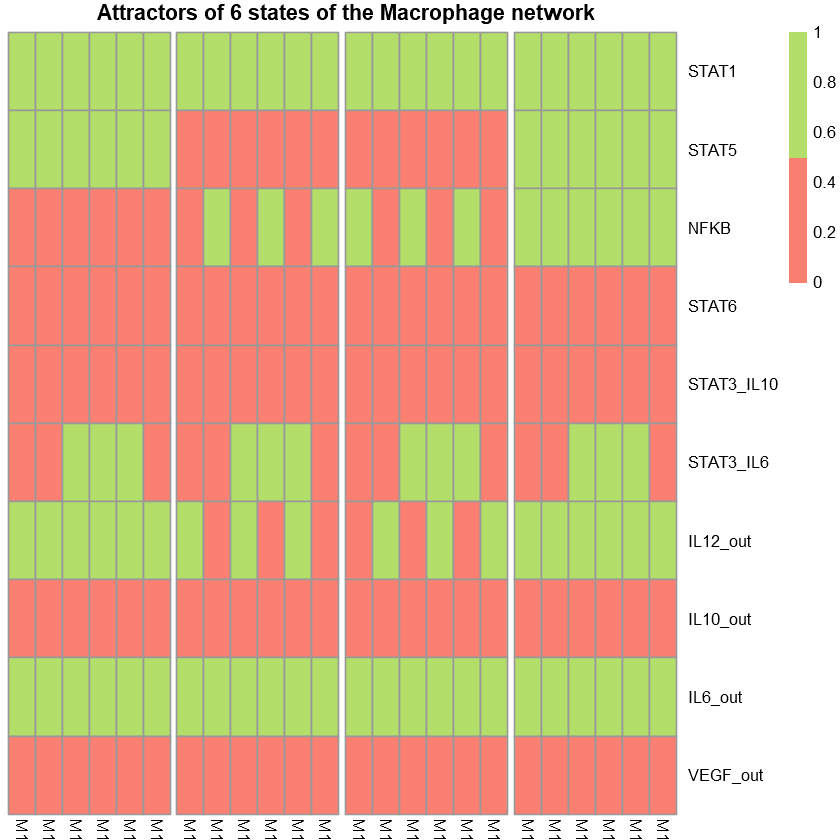

In [44]:
# Plotting the heatmaps of the unique attractors
plot.heatmap <- function(attr.table, title, gaps){
      pheatmap(t(as.matrix( subset(attr.table, select=-c(attractor,state) ))),
               labels_col = attr.table[,"attractor"],
               main= title,
               color=c('#fb8072','#b3de69'),
               cluster_cols = F, cluster_rows = F,
               gaps_col = gaps, scale = "none"
      )
}
save.png <- F
save.pdf <- F
if (! file.exists(file.attr.pdf)) { pdf(file.attr.pdf); save.pdf <- T}
for(size in cycle.sizes){
      print(size)
      size.attr <- nrow(attr.cycles.list[[size]])/size
      title <- paste0("Attractors of ", size, " states of the Macrophage network")
      for(block in 1:ceiling(size.attr/24)){
            up.limit <- block*24
            low.limit <- ((block-1)*24)+1
            gap <- 24
            if(all(is.na(attr.cycles.list[[size]][up.limit,]))){
                  up.limit <- (low.limit-1) + nrow(na.omit(attr.cycles.list[[size]][low.limit:up.limit,]))
                  gap <- nrow(na.omit(attr.cycles.list[[size]][low.limit:up.limit,]))
            }
            if (save.png){
            plot.name <- paste0("PLOT/MP_heatmap_size", size, "_block", block, ".png")
            png(plot.name)
            }
            plot.heatmap(attr.table = attr.cycles.list[[size]][low.limit:up.limit,],
                         title = title,
                         gaps = seq(size, gap, size))
            if (save.png) dev.off()
      }
}
if (save.pdf) dev.off()


## Enviroments

In [39]:
labels

labels,rules
M0,!(IL12_out | IL10_out | IL6_out | VEGF_out)
il6,IL6_out & !(IL12_out | IL10_out | VEGF_out)
M1,(IL12_out) & ( IL6_out | STAT1 | STAT5 | NFKB ) & ! (IL10_out | VEGF_out)
M2,(IL10_out | VEGF_out) & ! IL12_out
a,(IL10_out & STAT6) & ! ( IL12_out | IL6_out | NFKB | VEGF_out | FCGR)
b,(IL10_out) & (IL6_out) & ! ( STAT6 |VEGF_out)
c,(IL10_out & STAT3_IL10 ) & ! ( IL12_out | IL6_out | NFKB | STAT6 | VEGF_out)
d,(VEGF_out) & ! (IL12_out | IL6_out | NFKB | STAT6 )
M1M2,IL10_out & IL12_out


In [48]:
read.csv(file.env)

Warning message in file(file, "rt"):
"no fue posible abrir el archivo 'CSV/MP_enviroments_analysis_2.csv': No such file or directory"

ERROR: Error in file(file, "rt"): no se puede abrir la conexión


In [50]:
file.env <- "CSV/MP_enviroments_analysis_2.csv"
if (! file.exists(file.env)) {
    labels <- read.csv("CSV/MP_label_rules_2.csv")
    estimulus <- net$genes[str_detect(net$genes, "_e")]
    set.env <- function(genes, estimulus){
        ind <- match(genes, estimulus)
        env <- rep(0, length(estimulus))
        env[ind] <- 1
        names(env) <- estimulus
        env
    }
    pro_M1 <- set.env(c("IFNG_e", "LPS_e", "GMCSF_e"), estimulus)
    pro_M2a <- set.env(c("IL4_e"), estimulus)
    pro_M2b <- set.env(c("LPS_e","IC_e", "IL1B_e"), estimulus)
    pro_M2c <- set.env(c("IL10_e"), estimulus)
    pro_M2d <- set.env(c("LPS_e", "IL6_e", "NECA_e"), estimulus)
    envMacrophages <- list(label = c("pro_M1", "pro_M2a", "pro_M2b", "pro_M2c", "pro_M2d"),
                       nodes = list(estimulus,estimulus,estimulus,estimulus,estimulus),
                       values = list(pro_M1, pro_M2a, pro_M2b, pro_M2c, pro_M2d))
    env.attr <- perturbNetworkFixedNodes(net, label.rules = labels,
                                     genes = envMacrophages$nodes,
                                     values = envMacrophages$values,
                                     names = envMacrophages$label,
                                     method = "sat.restricted",
                                     maxAttractorLength = 2)
    write.csv(x = env.attr, file = file.env)
} else {
    env.attr <- read.csv(file.env)
}

# Plot enviroments
env.attr

X,pro_M1,pro_M2a,pro_M2b,pro_M2c,pro_M2d
M1/M1,1,0,0,0,0
M2/M2,0,0,0,0,1
M2a,0,1,0,0,0
M2b/M2b,0,0,1,0,0
M2c,1,0,0,1,0
M2d,0,0,0,0,1


# Macrophage Plasticity new labels

In [13]:
simplifyLabel <- function(old, sep='/', mark='*', replace=NULL) {
      new <- str_split(old,sep)
      new <- sort(unique(new[[1]]))
      new <- paste(new, collapse=sep)
      if (! is.null(replace)) {
            for (key in names(replace)) {
                  new <- str_replace( new, pattern=key, replace[[key]] )
            }
      }
      if (! is.null(mark)) {
            if (new!=old) {
                  new <- paste(c(new,mark), collapse='')
            }
      }
      new
}

replace <- list('bM1M2'='M1M2', 'il6/M0/M1/M2b'='M1M2', 'il6/M0/M2/M2b'='M2b', 'il6/M0/M2/M2c'='M2c', 'il6/M0/M1/M2'='M1M2',
                'M1M2/M2/M2d'='M1M2', 'il6/M1/M2b'='M1M2', 'il6/M0/M1'='M1', 'il6/M0/M2'='M2', 'M0/M1/M2b'='M1M2', 'M0/M2/M2b'='M2b',
                'M0/M2/M2c'='M2c', 'M1/M2/M2b'='M1M2', 'M1/M2/M2c'='M1M2', 'M0/M1/M2'='M1M2', 'il6/M2b'='M2b', 'M1M2/M2'='M1M2',
                'il6/M0'='il6', 'il6/M1'='M1', 'il6/M1'='M1', 'M1/M2b'='M1M2', 'M2/M2d'='M2d', 'M0/M1'='M1', 'M0/M2'='M2', 'M1/M2'='M1M2')

In [ ]:
net <- loadNetwork(file = "CSV/MP_reduced_network_1.2.csv")
attr <- getAttractors(net, type="synchronous", method = "sat.restricted", maxAttractorLength = 2,
                      returnTable  = TRUE)
attr.table <- attractorToDataframe(attr)
cellfate.nolabel.file <- "CSV/MP_cellfate_nolabel_2.csv"
f.cfm.table <- function(net, file.name) {
   if (! file.exists(file.name)) {
      cfm <- cellFateMap(net,
                         method="sat.restricted", maxAttractorLength=2)
      cfm <- apply(cfm,2,as.character)
      cfm <- cfm[  order( cfm[,1], cfm[,2], cfm[,3], cfm[,4] ),]
      write.csv(cfm,file.name, row.names=F)
   } else {
      cfm <- read.csv(file = file.name)
   }
   cfm }
cfm <- f.cfm.table(net, cellfate.nolabel.file)
lab <- read.csv("CSV/MP_label_rules_2.csv")
labels <- labelAttractors(attr, lab, net$genes)
clean.labels <- list()
for (i in 1:length(labels)) {
      clean.labels[i] <- simplifyLabel(labels[[i]], replace=replace)
}

clean.labels <- unlist(clean.labels)
attr.table <- data.frame(int.attractor = attr.table$involvedStates,
                    labels = clean.labels)
attr.table <- apply(attr.table, 1, function(attractor){
   if(str_detect(attractor["int.attractor"],"/")){
      attractor.split <- str_split(attractor["int.attractor"], "/")[[1]]
      attractor <- data.frame(int.attractor = attractor.split,
                 labels = rep(as.character(attractor["labels"]), length(attractor.split)))
      return(attractor)
   } else { return(as.data.frame(t(attractor)))}
})
attr.table <- as.data.frame(rbindlist(attr.table))
attr.table$int.attractor <- as.integer(attr.table$int.attractor)

In [ ]:
cfm <- apply(cfm, 1, function(perturb){
   initial <- as.integer(perturb["initial"])
   perturb["initial"] <- attr.table$labels[which(attr.table$int.attractor == initial)]
   if(str_detect(perturb["final"], "/")){
      final <- as.integer(str_split(perturb["final"],"/")[[1]]) 
   } else { final <- as.integer(perturb["final"]) }
   initial <- attr.table[which(attr.table$int.attractor == initial),"label"]
   final <- attr.table[which(attr.table$int.attractor == final),"label"]
   final <- paste(final, collapse = "/")
   as.data.frame(t(perturb))
})
cfm <- Filter(function(row) any(!is.na(row)), cfm)
cfm <- rbindlist(cfm)

## Macrophage Plasticity

In [1]:
decimal.states.file <- "CSV/MP_decimal_states_2.csv"
if (! file.exists(decimal.states.file)) {
    attr.nolabel <- getAttractors(net, type="synchronous", method = "sat.restricted", maxAttractorLength = 6,
                          returnTable  = TRUE)
    states <- attractorToDataframe(attr.nolabel)
    states <- states$involvedStates

    decimal.st <- unlist(unname(sapply(states, function(state){
          if(str_detect(state, "/")){
             cycle.state <- str_split(state, "/")[[1]]
             return(paste0(cycle.state,"*"))
          } else {
             return(state)
          }
       })))
    labels <- read.csv("CSV/MP_label_rules_2.csv")
    states.class <- sapply(decimal.st, function(state){
       cycle <- F
       if(str_detect(state, "\\*")){
          cycle <- T
          state <- as.integer(str_extract(state, "\\d+"))
       } else {
          stat <- as.integer(state)
       }
       bin.st <- int2binState(state, net$genes)
       lab <- labelState(state = bin.st, node.names = net$genes, label.rules = labels, sep = "/")
       if(cycle) lab <- paste0(lab,"*")
       lab
    })
    decimal.st <- unname(sapply(decimal.st, function(state){
      if(str_detect(state, "\\*")) { state <- as.integer(str_extract(state, "\\d+"))
      } else {state <- as.integer(state)}
       state
    }))
    indexes.states <- data.frame(dec.attractor = decimal.st, label = states.class, 
                                 row.names = 1:length(decimal.st))
    write.csv(indexes.states, decimal.states.file)
    } else {
    indexes.states <- read.csv(decimal.states.file)
}

ERROR: Error in getAttractors(net, type = "synchronous", method = "sat.restricted", : no se pudo encontrar la función "getAttractors"


In [9]:
cellfate.nolabel.file <- "CSV/MP_cellfate_nolabel_2.csv"
if (! file.exists(cellfate.nolabel.file)) {
    f.cfm.table <- function(net, file.name) {
        if (! file.exists(file.name)) {
            cfm <- cellFateMap(net, 
                               method="sat.restricted", maxAttractorLength=2) 
            cfm <- apply(cfm,2,as.character)
            cfm <- cfm[  order( cfm[,1], cfm[,2], cfm[,3], cfm[,4] ),]
            write.csv(cfm,file.name, row.names=F)
        } else {
            cfm <- read.csv(file = file.name)
        }
        cfm }
    cfm <- f.cfm.table(net, cellfate.nolabel.file)
} 
cfm <- cbind(cfm, indexes = 1:nrow(cfm))
cellfate.label.file <- "CSV/MP_cellfate_label.csv"
if (! file.exists(cellfate.label.file)) {
    cfm <- apply(cfm, 1, function(perturb){
       initial <- as.integer(perturb["initial"])
       if(str_count(perturb["final"], "/") >= 1){ final <- as.integer(str_split(perturb["final"], "/")[[1]])
       } else { final <- as.integer(perturb["final"]) }
       initial <- indexes.states[which(indexes.states$dec.attractor == initial),"label"]
       final <- indexes.states[which(indexes.states$dec.attractor == final),"label"]
       if(!all(!str_detect(c(initial, final), "NoLabel"))){ return(NA)
       } else {
          final <- paste(final, collapse = "/") }
       perturb["initial"] <- initial
       perturb["final"] <- final
       as.data.frame(t(perturb))
    })
    cfm <- Filter(function(row) any(!is.na(row)), cfm)
    cfm <- rbindlist(cfm)
    write.csv(x = cfm, file = )
    } else {
        cfm <- read.csv(cellfate.label.file)
    }

In [33]:
# To delete cycle marks
'''cfm <- apply(cfm, 1, function(perturb){
   perturb["initial"] <- str_replace_all(perturb["initial"], "\\*+", "")
   perturb["final"] <- str_replace_all(perturb["final"], "\\*+", "")
   as.data.frame(t(perturb))
})
cfm <- rbindlist(cfm)
cfm2 <- cfm'''

In [10]:
# Simplyfiying the labels
final <- as.character(cfm$final)
cfm$final <- sapply(final, function(state){
   split.state <- str_split(state, "/")[[1]]
   if(length(unique(split.state)) == 1) { return(split.state[1])
   } else {
         state
      }
})
rm(final)
M0M1 <- which(cfm$final =="M0*/M1*")
cfm$final[M0M1] <- "M1*"

In [8]:
unique(cfm$final)

[1] "M0"                          "M1*"                        
 [3] "M2c"                         "M1*/M2b*/M1*/M1*/M2b*/M1*"  
 [5] "M2a"                         "M1"                         
 [7] "M1*/M2b*/M0*/M1*/M2b*/M0*"   "M2b*"                       
 [9] "M2b*/M1*/M1*/M2b*/M1*/M1*"   "M2d"                        
[11] "M2b"                         "M2b*/M2b*/M1*/M2b*/M2b*/M1*"

[1] "Transitions between cell types"
# A tibble: 48 x 3
# Groups:   initial [11]
   initial final                      freq
   <fct>   <chr>                     <int>
 1 M0      M0                          112
 2 M0      M1*                          24
 3 M0      M2c                           8
 4 M0*     M0                           24
 5 M0*     M1                           16
 6 M0*     M1*                         188
 7 M0*     M1*/M2b*/M0*/M1*/M2b*/M0*   344
 8 M0*     M2c                         368
 9 M1      M1                          336
10 M1      M1*                         144
# ... with 38 more rows


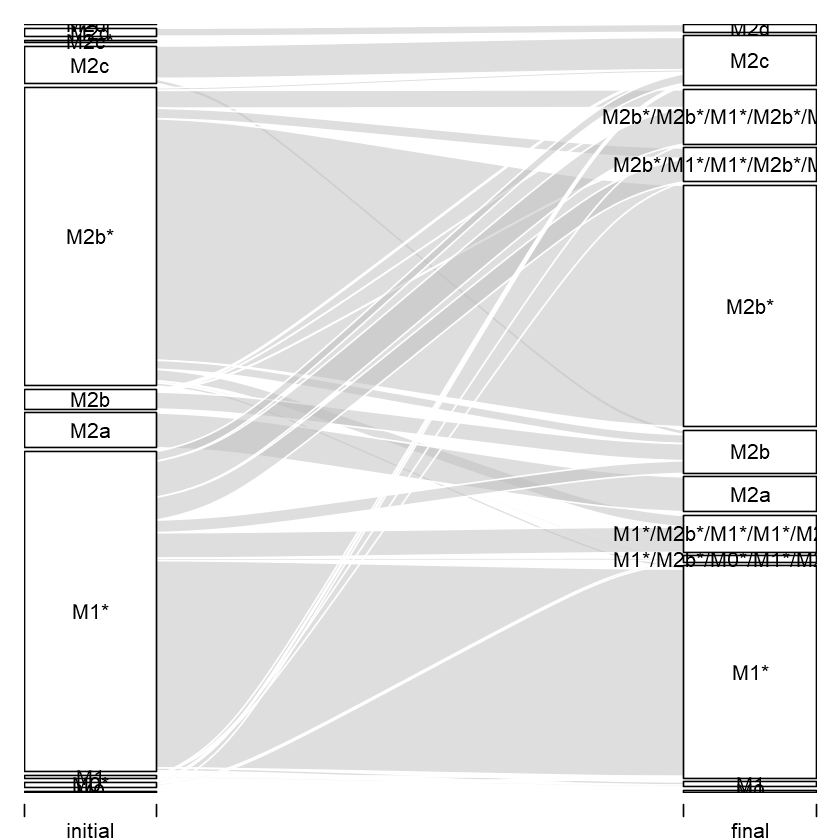

In [11]:
plot.cfm.alluvial <- function(cfm, file.name, title='', ignore='Naive') {
   if (! file.exists(file.name)) { 
      pdf(file.name) 
      save.pdf=T
   } else { 
      save.pdf <- F
   }
   cfm <- cfm[cfm$initial!=ignore,]
   cfm %>% group_by(initial, final) %>%
      summarize(freq = n()) -> cfm2d
   print(title)
   print(cfm2d)
   alluvial(cfm2d[,1:2], freq=cfm2d$freq)
   if (save.pdf) { dev.off() }
}
plot.cfm.alluvial(cfm, 'PLOT/MP_alluvial.pdf',
                  title='Transitions between cell types')

## Mutants

In [5]:
f.mut.plot <- function(mutants, image.name, save.pdf=FALSE, normalize=T) {
    if (save.pdf) { pdf(image.name) }
    if (normalize) {
        mutants <- mutants/mutants
        color <- c('#bebada')
    } else {
        colfunc <- colorRampPalette(c('#bfd3e6', '#810f7c'))
        color <- colfunc(10)
    }
    
    heatmap(t(as.matrix( mutants )),
            main="Macrophage subsets mutants", 
            xlab="Macrophage subset", ylab="Mutant",
            col=color, cexCol=0.75, cexRow=0.75,
            Colv = NA, Rowv = NA, scale="none",
           )
    if (save.pdf) {dev.off() }
}

In [6]:
mutants.file <- "CSV/MP_mutants_2.csv"
if (!file.exists(mutants.file)){
    lab <- read.csv(file = "CSV/MP_label_rules_2.csv")
    mutants <- perturbNetworkFixedNodes(net, label.rules = lab,
                                        method = "sat.restricted", maxAttractorLength = 2)
    write.csv(x = mutants, file = mutants.file)
    } else {
    mutants <- read.csv(file = mutants.file, row.names = 1)
    }

In [11]:
mutants

,WT,STAT1_0,STAT5_0,IL1R_0,IL12_out_0,FCGR_0,NFKB_0,VEGF_out_0,TLR4_0,IL6_out_0,...,IFNG_e_1,GMCSF_e_1,IL1B_e_1,IC_e_1,LPS_e_1,NECA_e_1,EGFR_e_1,IL4_e_1,IL6_e_1,IL10_e_1
il6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
il6*,156,288,168,70,288,188,72,172,218,0,...,12,72,24,62,16,70,88,0,88,0
M0,24,32,32,36,32,24,48,24,36,56,...,8,8,0,12,0,12,12,0,0,0
M0*,0,0,0,0,0,0,0,0,0,104,...,0,0,0,0,0,0,0,0,0,0
M1,8,0,0,12,0,8,16,8,12,40,...,8,8,0,4,0,4,4,0,0,0
M1*,132,0,120,34,0,164,24,148,182,88,...,132,72,24,50,16,58,72,0,72,0
M1/NoLabel*,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M1M2,0,0,0,0,0,0,0,0,0,48,...,0,0,0,0,0,0,0,0,0,0
M1M2*,96,0,96,96,0,0,48,96,96,48,...,96,48,64,96,64,48,48,0,48,48
M2,256,256,256,256,256,448,256,160,160,216,...,128,128,112,32,160,176,224,224,128,128


In [10]:
mutants.simplify.file <- "CSV/MP_mutants_simplifyLabel_1.csv"
if (!file.exists(mutants.file)){
    labels <- rownames(mutants)
    clean.labels <- list()
    for (i in 1:length(labels)) {
       clean.labels[i] <- simplifyLabel(labels[[i]], replace=replace)
    }
    clean.labels <- unlist(clean.labels)
    mutants <- aggregate(mutants, list(clean.labels), sum)
    rownames(mutants) <- mutants$Group.1
    mutants <- mutants[,-1]
    write.csv(x = mutants, file = mutants.simplify.file)
    } else {
    mutants <- read.csv(file = mutants.simplify.file, row.names = 1)
}

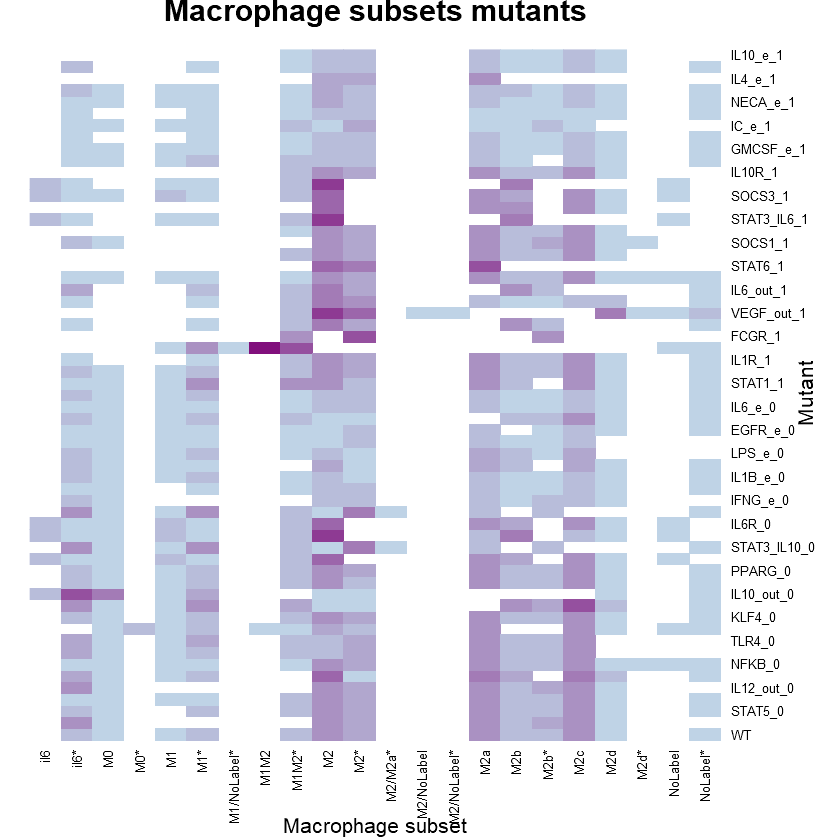

In [12]:
mutants[mutants==0] <- NA
f.mut.plot(mutants, image.name = "PLOT/MP_mut_wt.pdf", save.pdf=FALSE, normalize=F)